# [Computational Social Science] Project 4: Unsupervised Learning

**Enter your Name:** Chuxuan Gao

*Semester:* Fall 2024

## Data Description and Preprocessing

For this project, you will explore data from the [National Health and Nutrition Examination Survey](https://www.kaggle.com/cdc/national-health-and-nutrition-examination-survey?select=questionnaire.csv). NHANES is a unique study that combines survey methodology with in-person medical examinations to create a dataset with demographic information, health indicators, and health outcomes.

We start by importing the data and doing some preliminary preprocessing for you. We import some libraries that will be helpful as well. 'SEQN' is the ID number for each respondent, and 'HSD010' will be our target outcome. [HSD010](https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/HSQ_H.htm#HSD010) asks for the respondent's self reported health condition, which can range from "excellent" to "poor."

In [188]:
!pip install kneed

In [186]:
# Import libraries
import pandas as pd
import numpy as np
import math
import random
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
sns.set_style("darkgrid")
from sklearn.preprocessing import LabelEncoder
from matplotlib.patches import Ellipse
from scipy.stats import chi2
from kneed import KneeLocator
from sklearn.metrics import silhouette_score
from keras.utils import to_categorical
import keras
from tensorflow.keras.metrics import F1Score
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from sklearn.cluster import HDBSCAN

In [2]:
np.random.seed(10)
random.seed(10)

In [3]:
# Load nhanes data
nhanes = pd.read_csv('nhanes.csv')
# Get the ID numbers for each observation (seqn)
seqn = nhanes['SEQN']
# Get the target, "self-reported health condition," HSD010
hsd010 = nhanes['HSD010']
# Drop SEQN from the dataframe and then apply the standard scaler
nhanes = nhanes.drop(['SEQN', 'HSD010'], axis = 1)
nhanes_scaled = pd.DataFrame(StandardScaler().fit_transform(nhanes),
                             columns = nhanes.columns)
# Add the ID and target back in
nhanes_scaled['SEQN'] = seqn
nhanes_scaled['HSD010'] = hsd010
nhanes_scaled = nhanes_scaled.set_index('SEQN')
nhanes_scaled.head()

,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,...,OHQ770,OHQ845,PAAQUEX,SMQ860,SMQ870,SMQ872,SMQ874,SMQ878,SMAQUEX.x,HSD010
SEQN,,,,,,,,,,,,,,,,,,,,,
73568,0.0,2.034312,0.0,0.324834,-0.393906,1.085853,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-0.646584,-0.484200,1.125008,0.0,-2.081666,1.087115,1.463404,0.612440,1
73576,0.0,0.261930,0.0,-3.078499,0.568251,0.634362,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-1.539259,-0.484200,1.125008,0.0,-2.081666,1.087115,-0.683338,-1.632812,1
73579,0.0,0.728346,0.0,0.324834,1.530407,-1.623092,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-1.539259,2.065262,-0.888883,0.0,0.480384,-0.919866,-0.683338,-1.632812,2
73581,0.0,-0.857470,0.0,0.324834,0.480782,1.085853,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-0.646584,-0.484200,1.125008,0.0,0.480384,-0.919866,-0.683338,0.612440,2
73584,0.0,0.495138,0.0,0.324834,0.305844,-1.623092,-0.194202,-0.057306,0.128246,0.080373,...,-2.605509,0.246091,2.065262,1.125008,0.0,0.480384,-0.919866,1.463404,-1.632812,3


## Plots

Let's take a look at the data. Below we visualize boxplots of family income to federal poverty line ratio ('INDFMPIR') and self-reported health condition. Notice how there are some clear patterns (the lower the ratio, the lower reported health condition), but it's not a perfect separation. We have 240+ features in our dataset, and we likely have several features in our dataset that highly correlate with our family income-poverty line ratio measure - PCA will help us simplify these.

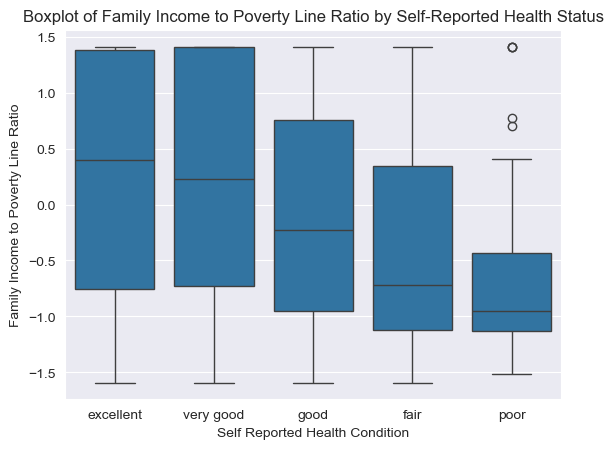

In [6]:
# Create a binary version of hsd010 where 1-3 are "good" and 4-5 are "poor"
nhanes_scaled['HSD010_binary'] = hsd010_binary = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['good', 'good', 'good', 'poor', 'poor']) 
# Recode the original hsd010 with the string labels
nhanes_scaled['HSD010'] = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['excellent', 'very good', 'good', 'fair', 'poor'])
# Boxplot of hsd010
ax = sns.boxplot(x = 'HSD010', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Self-Reported Health Status")
plt.show()

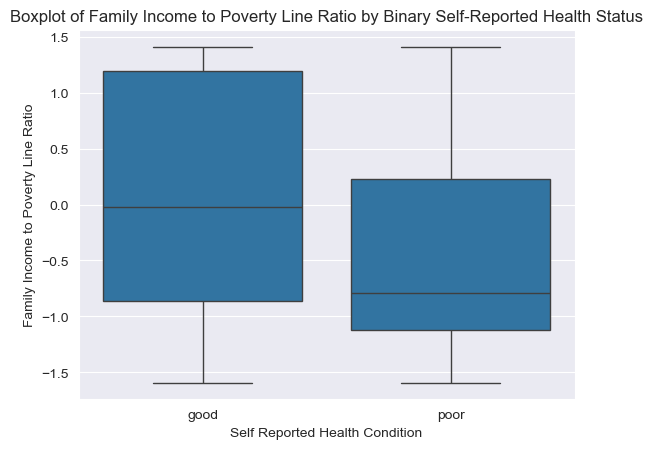

In [7]:
# Boxplot of hsd010_binary
ax = sns.boxplot(x = 'HSD010_binary', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Binary Self-Reported Health Status")
plt.show()

Family income also is not necessarily well correlated with measured health outcomes. See below where we look at the relationship between Body Mass Index (BMI) and the family income-poverty line ratio, and shade points by self-reported health condition. It's hard to find a clear pattern - this is where clustering may come in handy. 

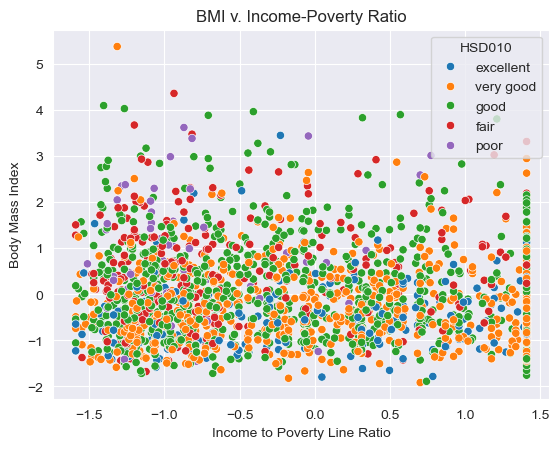

In [9]:
ax = sns.scatterplot(x = "INDFMPIR", y = "BMXBMI", hue = "HSD010", palette = "tab10", data = nhanes_scaled)
ax.set(xlabel = "Income to Poverty Line Ratio",
      ylabel = "Body Mass Index")
ax.set_title("BMI v. Income-Poverty Ratio")
plt.show()

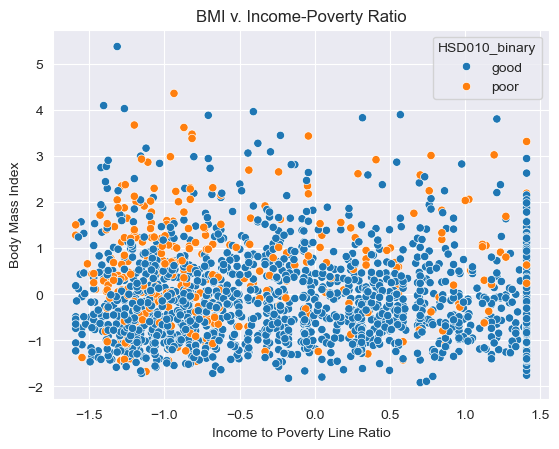

In [10]:
ax = sns.scatterplot(x = "INDFMPIR", y = "BMXBMI", hue= "HSD010_binary", data = nhanes_scaled)
ax.set(xlabel = "Income to Poverty Line Ratio",
      ylabel = "Body Mass Index")
ax.set_title("BMI v. Income-Poverty Ratio")
plt.show()

Before we move to working on unsupervised methods, we'll drop our target variables again:

In [12]:
target = nhanes_scaled['HSD010_binary']

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(target)

print()
for index, class_name in enumerate(label_encoder.classes_):
    print(f"{class_name}: {index}")


good: 0
poor: 1


In [15]:
nhanes_scaled = nhanes_scaled.drop(['HSD010', 'HSD010_binary'], axis = 1)

## Principal Component Analysis

Conduct a Principal Component Analysis (PCA) of the nhanes data. The data has already been prepared for you, so you can work directly on nhanes_scaled. Be sure to do the following:

- Choose the number of components and provide 1-2 sentences about your choice of the number of components. 
- Plot a barplot of the variation explained by each component. *Hint*: look at the attributes associated with your model. 
- Choose how many components you will use to fit a supervised learning model and provide 1-2 sentences to explain that choice.
- Plot a 2D scatterplot of the first two components and provide 1-2 sentences analyzing the plot.

### Train PCA and Discuss Number of Components

In [26]:
pca_all = PCA() 
pca_all_nhanes = pca_all.fit_transform(nhanes_scaled)

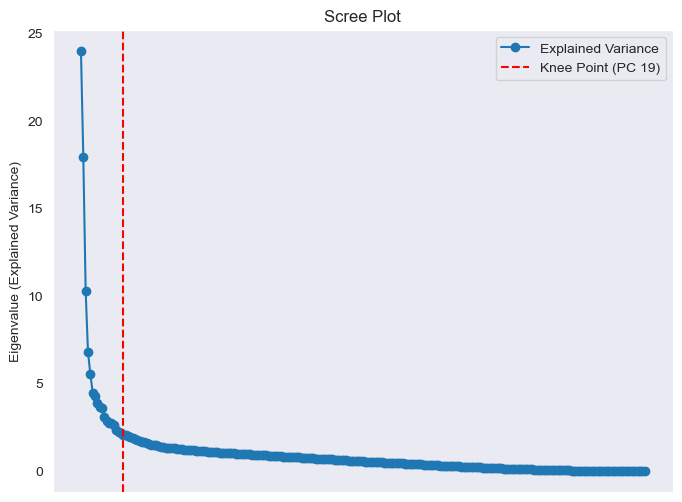

According to the scree plot, the optimal number of pricipal components is 19


In [297]:
explained_variance = pca_all.explained_variance_  

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='-', label='Explained Variance')
plt.xticks([])
plt.ylabel('Eigenvalue (Explained Variance)')
plt.title('Scree Plot')

from kneed import KneeLocator
knee_locator = KneeLocator(range(1, len(explained_variance) + 1), explained_variance, curve="convex", direction="decreasing")
knee_point = knee_locator.knee
plt.axvline(x=knee_point, color='r', linestyle='--', label=f'Knee Point (PC {knee_point})')

plt.legend()
plt.grid()
plt.show()

print(f"According to the scree plot, the optimal number of pricipal components is {knee_point}")

### Barplot of Components

In [31]:
explained_variance_ratio = pca_all.explained_variance_ratio_

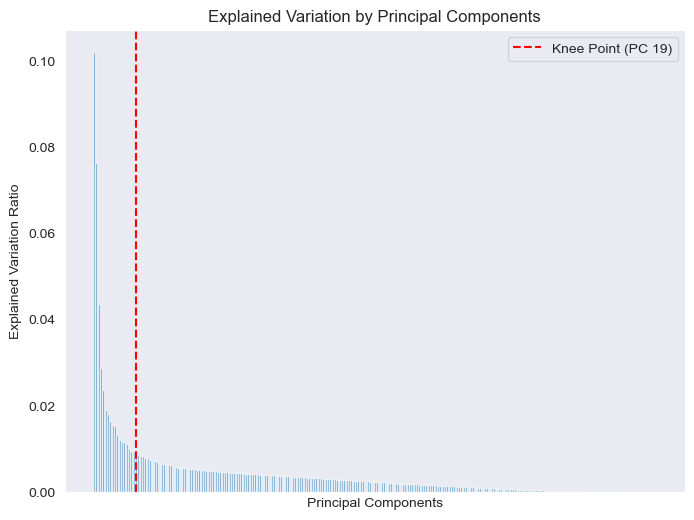

In [33]:
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.7, align='center')
plt.axvline(x=knee_point, color='r', linestyle='--', label=f'Knee Point (PC {knee_point})')


plt.title('Explained Variation by Principal Components')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variation Ratio')
plt.xticks([]) 
plt.legend()
plt.grid()
plt.show()

The first principle component explains about 10% variance and the second explains about another 8% of the variance.  
Principle components after the first 19 provide little additive explained variance and may not contain much meaningful information. 

### How many components will you use to fit a supervised learning model?

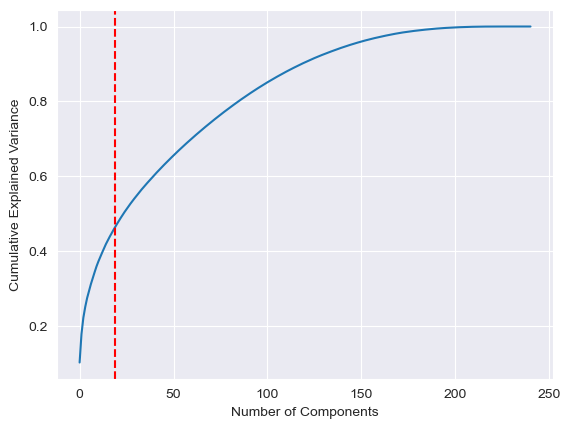

In [37]:
plt.plot(np.cumsum(pca_all.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.axvline(x=knee_point, color='r', linestyle='--', label=f'Knee Point (PC {knee_point})')
plt.show()

In [39]:
cumulative_variance = np.cumsum(explained_variance_ratio)
print(f"Variance explained by the first 19 principle components：{cumulative_variance[18]:.4f}")

Variance explained by the first 19 principle components：0.4561


In [219]:
pca_19 = PCA(n_components = 19)
nhanes_reduced_19 = pca_19.fit_transform(nhanes_scaled)

In [295]:
pca_df_19 = pd.DataFrame(
    nhanes_reduced_19,
    columns=[f'PC{i+1}' for i in range(nhanes_reduced_19.shape[1])] 
)

The number of principal components determined by the scree plot is 19, which explains only about **46% of the variance**; this might result in losing too much information for a supervised model.   
An alternative common criterion is to use the explained variance ratio. The results show that **120 principle components** are required to explain **90% of the variance**, reducing the number of original features by half. This reduction can speed up computation and lower computational costs.

In [43]:
pca_90 = PCA(n_components = 0.90)
nhanes_reduced_90 = pca_90.fit_transform(nhanes_scaled)
pca_90.n_components_

120

In [301]:
pca_df_120 = pd.DataFrame(
    nhanes_reduced_90,
    columns=[f'PC{i+1}' for i in range(nhanes_reduced_90.shape[1])] 
)

### 2D Scatterplot of the first two components

In [85]:
pca_2d = PCA(n_components=2)
pca_2d_nhanes = pca_2d.fit_transform(nhanes_scaled)

In [86]:
pca_df_2d = pd.DataFrame(data = pca_2d_nhanes, 
                      columns = ['principal component 1', 
                                 'principal component 2'])

<Figure size 640x480 with 0 Axes>

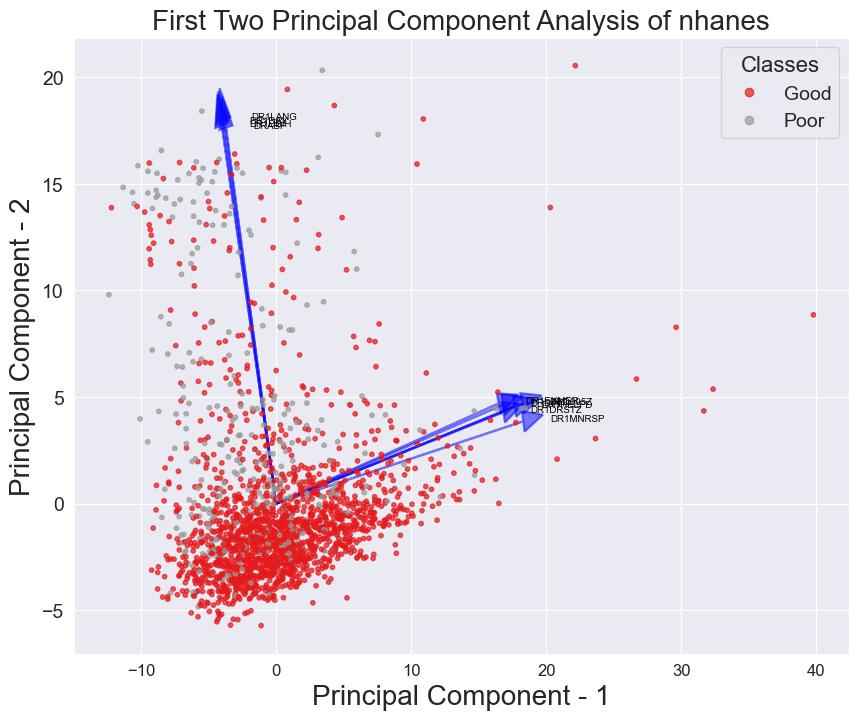

In [88]:
plt.figure()
plt.figure(figsize=(10,8))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Principal Component - 1',fontsize=20)
plt.ylabel('Principal Component - 2',fontsize=20)
plt.title("First Two Principal Component Analysis of nhanes",fontsize=20)


feature_names = nhanes_scaled.columns.tolist()
loadings = pca_2d.components_.T
contribution = np.sum(np.abs(loadings), axis=1)
top_features_idx = np.argsort(contribution)[-10:]  
top_features = [nhanes_scaled.columns[i] for i in top_features_idx]
top_loadings = loadings[top_features_idx]  


for i, (n, k) in enumerate(top_loadings):
    plt.arrow(0, 0, n * 100, k * 100, color='blue', alpha=0.5, head_width=1, linewidth=1.5)
    plt.text(n * 100+2, k * 100, feature_names[i], fontsize=7, color='black')


scatter = plt.scatter(
    pca_df_2d['principal component 1'],  
    pca_df_2d['principal component 2'],                        
    c=y,                      
    cmap='Set1',             
    s=10,                    
    alpha=0.7)


legend_labels = ['Good', 'Poor']  
legend_elements = scatter.legend_elements()[0] 
plt.legend(
    legend_elements, legend_labels,  
    title="Classes",                 
    fontsize=14,                     
    title_fontsize=16                
)


plt.show()

The arrows stands for original features that have the most significant influence on the first two principle components. They are highly overlapping, which indicates that these original features are highly correlated. These features might be redundant, as they likely describe similar information. Using PCA helps to reduce redundancy and retain the most informative components.

## Clustering: K-Means

- Choose a clustering algorithm and explain it in 1-2 sentences.
- Cluster the nhanes data. Detail any choice you need to make with regards to number of clusters, and how you arrived at that choice. For instance, you might use the [elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering)) if you choose k-means.
- Plot your clusters on top of BMI v. Income Poverty Ratio Plot. Describe what you see in 1-2 sentences.
- Retrain the clustering algorithm, but this time use your PCA results instead of the original dataframe. Plot the clusters on top of the 2D PCA scatterplot from the previous step. Describe your results in 1-2 sentences.

### Choose a Clustering Algorithm

**k-means** 

K-means aims to divide a dataset into k clusters, where each data point belongs to the cluster with the nearest centroid. It groups data using nearest distance by following steps: 1.	Randomly select K centroids (initial cluster centers). 2.	Assign each data point to the cluster of its nearest centroid. 3.	Recompute the centroid for each cluster. 4.	Repeat steps 2 and 3 until centroids no longer change (or until a specified number of iterations is reached).

K-means is simple to use and applicable to high-dimensional datasets (although performance will degrade), unlike DBSCAN, which especially struggles with such data. 
However, K-means can be unstable because its results depend on the initial selection of centroids and may converge to a local optimum.
K-means clustering can yield different clusters with each run because it starts with randomly chosen centroids. Since the k-means algorithm reaches a local minimum rather than a global one, the results may vary depending on the initial centroid selection. This sensitivity to initialization suggests that k-means clusters aren’t always definitive or reflect an absolute “ground truth.” 

### Cluster nhanes

In [100]:
n = nhanes_scaled.shape[0]
naive_k = int(math.sqrt(n/2))
naive_k

32

Apart from using the **elbow method** to analyze SSE, I will also refer to the **silhouette score** to choose the optimal K.   
The silhouette score can be understood as a measure of how well-defined the clusters are after clustering. It considers two factors: cohesion and separation. Cohesion reflects how closely a sample is related to other elements within the same cluster, while separation reflects how distinct a sample is from elements in other clusters. The closer the silhouette score is to 1, the better the clustering performance.

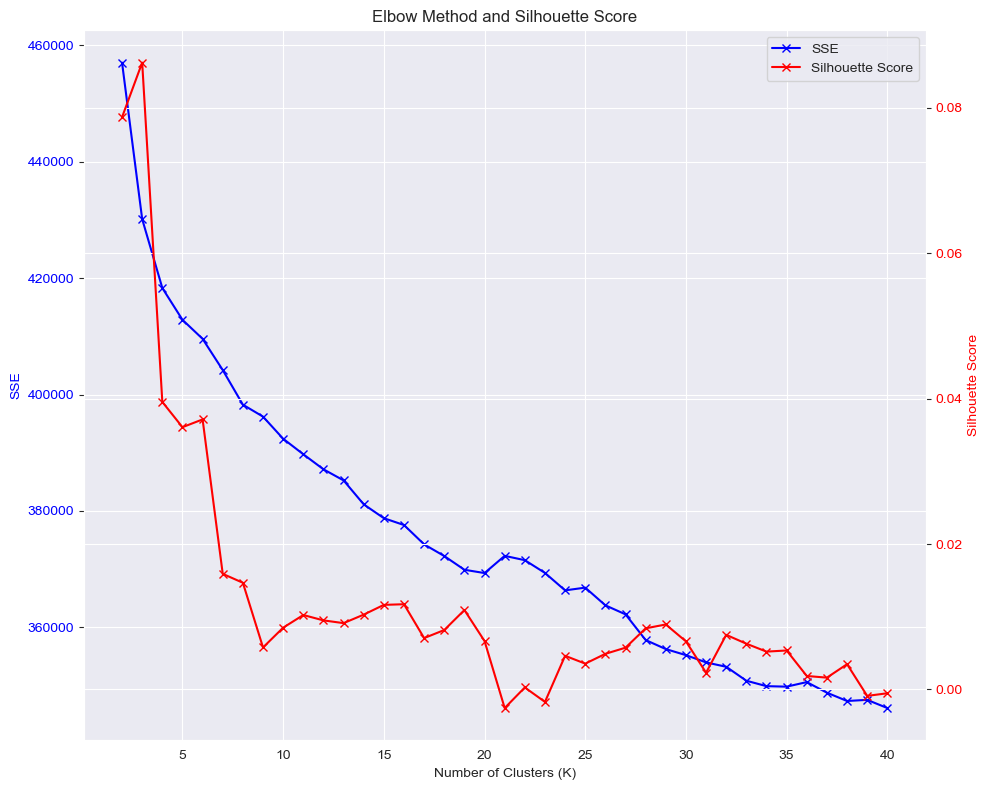

In [103]:
sse = []
silhouette_scores = []
k_values = range(2, 41)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=10)
    kmeans.fit(nhanes_scaled)
    
    sse.append(kmeans.inertia_)
    
    labels = kmeans.labels_
    silhouette_scores.append(silhouette_score(nhanes_scaled, labels))

fig, ax1 = plt.subplots(figsize=(10, 8))

sse_line, = ax1.plot(k_values, sse, 'bx-', label='SSE')
ax1.set_xlabel('Number of Clusters (K)')
ax1.set_ylabel('SSE', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
silhouette_line, = ax2.plot(k_values, silhouette_scores, 'rx-', label='Silhouette Score')
ax2.set_ylabel('Silhouette Score', color='red')
ax2.tick_params(axis='y', labelcolor='red')

lines = [sse_line, silhouette_line]  
labels = [line.get_label() for line in lines]
plt.legend(lines, labels, loc='best')

plt.title('Elbow Method and Silhouette Score')
fig.tight_layout()

plt.show()

The SSE decreases as K increases but seems do not contain an obvious, sharp elbow. The silhouette score peaks at K = 3 and significantly decreases with larger Ks.  
I will focus on smaller  K  values to identify the optimal choice. A smaller number of clusters may also provide higher interpretability and make it easier to understand and find meaningful information from the clustering results. 

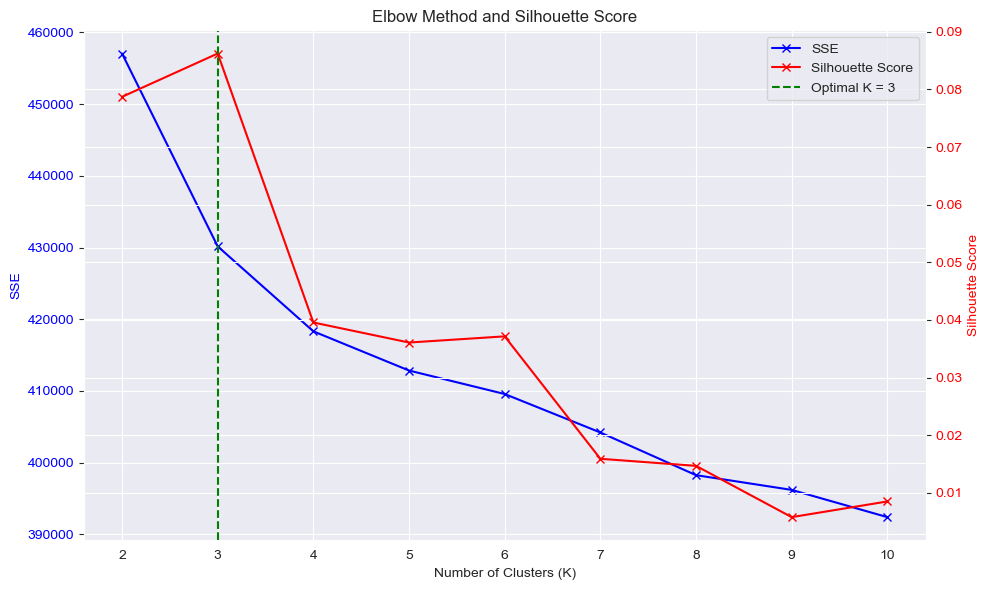

In [105]:
sse = []
silhouette_scores = []
k_values = range(2, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=10)
    kmeans.fit(nhanes_scaled)
    
    sse.append(kmeans.inertia_)
    
    labels = kmeans.labels_
    silhouette_scores.append(silhouette_score(nhanes_scaled, labels))


fig, ax1 = plt.subplots(figsize=(10, 6))

sse_line, = ax1.plot(k_values, sse, 'bx-', label='SSE')
ax1.set_xlabel('Number of Clusters (K)')
ax1.set_ylabel('SSE', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
silhouette_line, = ax2.plot(k_values, silhouette_scores, 'rx-', label='Silhouette Score')
ax2.set_ylabel('Silhouette Score', color='red')
ax2.tick_params(axis='y', labelcolor='red')

optimal_k = plt.axvline(x=3, color='g', linestyle='--', label=f"Optimal K = 3")

lines = [sse_line, silhouette_line, optimal_k]  
labels = [line.get_label() for line in lines]
plt.legend(lines, labels, loc='best')

plt.title('Elbow Method and Silhouette Score')
fig.tight_layout()

plt.show()

**Optimal K = 3**   
At  K = 3 , the silhouette score reaches a peak, suggesting a good balance between cohesion and separation. And the SSE shows a noticeable drop at  K = 3 , supporting this choice while keeping the clustering interpretable and computationally efficient.

### Plot your clusters on top of the BMI v. Income Poverty Ratio Plot

In [109]:
kmeans = KMeans(n_clusters=3,
                n_init=10,
                max_iter=300 
                ).fit(nhanes_scaled)

nhanes_scaled_kmeans = nhanes_scaled.copy()
nhanes_scaled_kmeans['cluster']  = kmeans.labels_

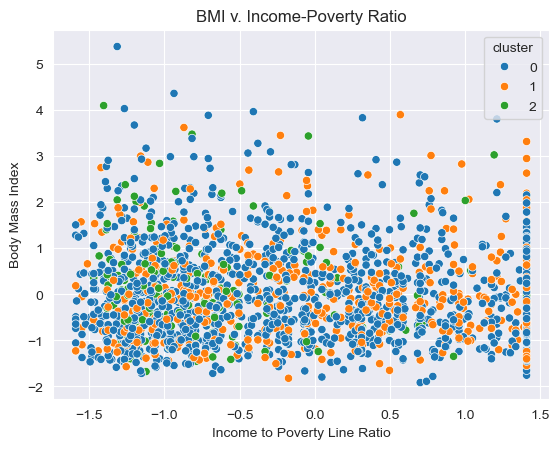

In [110]:
ax = sns.scatterplot(x = "INDFMPIR", y = "BMXBMI", hue = "cluster", palette = "tab10", data = nhanes_scaled_kmeans)

ax.set(xlabel = "Income to Poverty Line Ratio",
      ylabel = "Body Mass Index")
ax.set_title("BMI v. Income-Poverty Ratio")
plt.show()

This plot shows the original dataset **projected onto a 2D space defined by two features**, ‘BMI’ and ‘Income to Poverty Line Ratio,’ with clustering results overlaid.  
The significant overlap between clusters suggests that these two features alone cannot effectively separate the clusters. This overlap indicates that they are insufficient for dimensionality reduction or capturing the structure of the data.   
As demonstrated below, PCA provides a better approach by creating new axis through linear combinations of the original ones, improving the clustering projection and interpretability.

### Retrain the clustering algorithm on PCA components and plot clusters on your 2D scatter

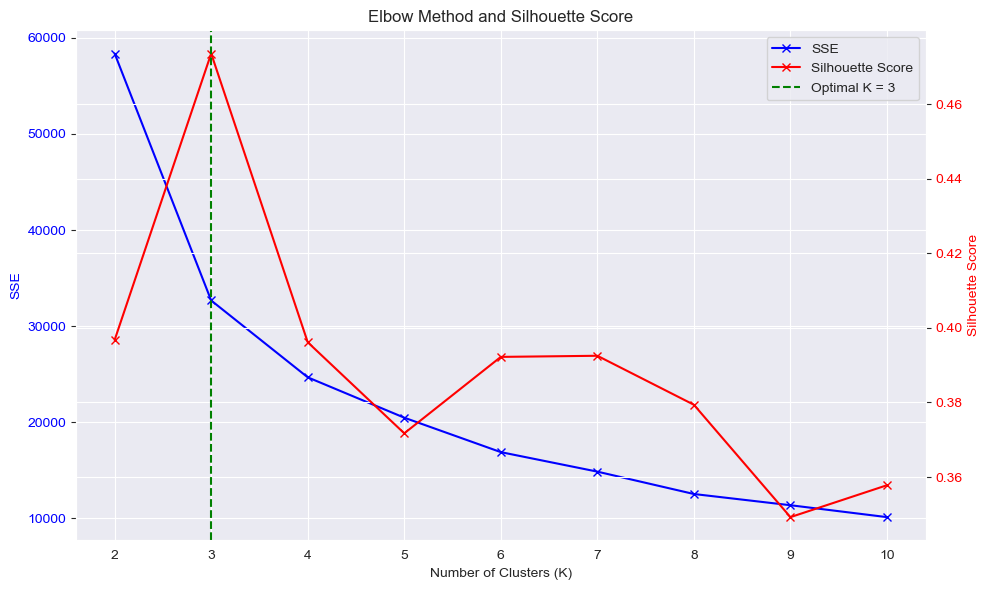

In [114]:
sse = []
silhouette_scores = []
k_values = range(2, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=10)
    kmeans.fit(pca_2d_nhanes)
    
    sse.append(kmeans.inertia_)
    
    labels = kmeans.labels_
    silhouette_scores.append(silhouette_score(pca_2d_nhanes, labels))


fig, ax1 = plt.subplots(figsize=(10, 6))

sse_line, = ax1.plot(k_values, sse, 'bx-', label='SSE')
ax1.set_xlabel('Number of Clusters (K)')
ax1.set_ylabel('SSE', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
silhouette_line, = ax2.plot(k_values, silhouette_scores, 'rx-', label='Silhouette Score')
ax2.set_ylabel('Silhouette Score', color='red')
ax2.tick_params(axis='y', labelcolor='red')

optimal_k = plt.axvline(x=3, color='g', linestyle='--', label=f"Optimal K = 3")

lines = [sse_line, silhouette_line, optimal_k]  
labels = [line.get_label() for line in lines]
plt.legend(lines, labels, loc='best')

plt.title('Elbow Method and Silhouette Score')
fig.tight_layout()

plt.show()

In [116]:
kmeans = KMeans(n_clusters=3,
                n_init=10,
                max_iter=300,
                random_state = 10).fit(pca_df_2d)

pca_2d_kmeans = pca_df_2d.copy()
pca_2d_kmeans['cluster']  = kmeans.labels_

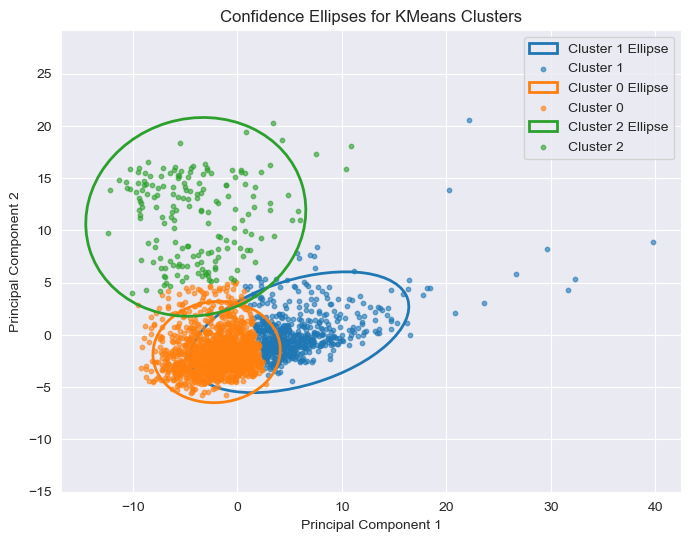

In [120]:
confidence_level = 0.95
chi2_val = chi2.ppf(confidence_level, df=2)  


plt.figure(figsize=(8, 6))
colors = {cluster: plt.cm.tab10(i) for i, cluster in enumerate(pca_2d_kmeans['cluster'].unique())}


for cluster in pca_2d_kmeans['cluster'].unique():
    cluster_data = pca_2d_kmeans[pca_2d_kmeans['cluster'] == cluster]
    
    
    mean = cluster_data[['principal component 1', 'principal component 2']].mean().values
    cov = np.cov(cluster_data[['principal component 1', 'principal component 2']].values, rowvar=False)
    
    
    eigvals, eigvecs = np.linalg.eigh(cov)  
    angle = np.degrees(np.arctan2(*eigvecs[:, 0][::-1]))  
    width, height = 2 * np.sqrt(eigvals * chi2_val)  

    
    ellipse = Ellipse(
        xy=mean, width=width, height=height, angle=angle,
        edgecolor=colors[cluster], facecolor='none', linewidth=2, label=f'Cluster {cluster} Ellipse'
    )
    plt.gca().add_patch(ellipse)
    
    
    plt.scatter(cluster_data['principal component 1'], 
                cluster_data['principal component 2'], 
                alpha=0.6, 
                s=10,
                color=colors[cluster], 
                label=f'Cluster {cluster}')


plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Confidence Ellipses for KMeans Clusters')
plt.legend(loc='best')
plt.axis('equal')
plt.show()

The clustering visualization using PCA shows a more distinct structure compared to the scatter plot based on ‘BMI’ and ‘Income to Poverty Line Ratio,’ indicating that PCA provides a better 2D projection for the dataset.   
However, the overlapped confidence ellipses reflects the limitations of K-means, which assumes **spherical cluster distributions** and is **sensitive to outliers**. 

In [124]:
clusterer = HDBSCAN(min_cluster_size=10)
hdbscan = clusterer.fit_predict(pca_df_2d)

pca_2d_hdbscan = pca_df_2d.copy()
pca_2d_hdbscan['cluster']  = clusterer.labels_

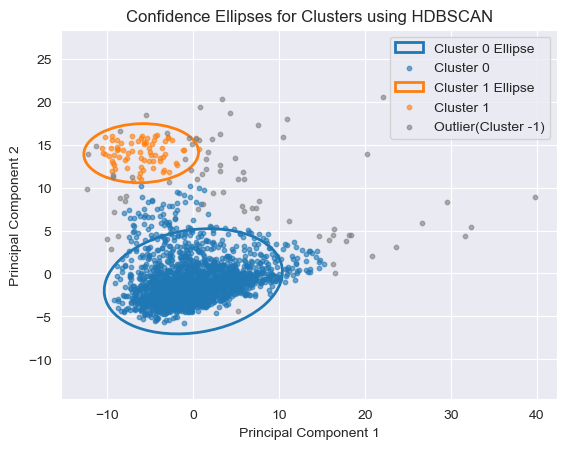

In [317]:
colors = {cluster: plt.cm.tab10(i) for i, cluster in enumerate(pca_2d_hdbscan['cluster'].unique())}
colors[-1] = 'gray' 


for cluster in pca_2d_hdbscan['cluster'].unique():
    cluster_data = pca_2d_hdbscan[pca_2d_hdbscan['cluster'] == cluster]
    
    if cluster == -1:  
        plt.scatter(
            cluster_data['principal component 1'], 
            cluster_data['principal component 2'], 
            alpha=0.6, 
            s=10,
            color=colors[cluster], 
            label=f'Outlier(Cluster {cluster})'
        )
        continue  

    mean = cluster_data[['principal component 1', 'principal component 2']].mean().values
    cov = np.cov(cluster_data[['principal component 1', 'principal component 2']].values, rowvar=False)
    eigvals, eigvecs = np.linalg.eigh(cov)
    angle = np.degrees(np.arctan2(*eigvecs[:, 0][::-1]))
    width, height = 2 * np.sqrt(eigvals * chi2_val)
    
    ellipse = Ellipse(
        xy=mean, width=width, height=height, angle=angle,
        edgecolor=colors[cluster], facecolor='none', linewidth=2, label=f'Cluster {cluster} Ellipse'
    )
    plt.gca().add_patch(ellipse)
    
    plt.scatter(
        cluster_data['principal component 1'], 
        cluster_data['principal component 2'], 
        alpha=0.6, 
        s=10,
        color=colors[cluster], 
        label=f'Cluster {cluster}'
    )

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Confidence Ellipses for Clusters using HDBSCAN')
plt.legend(loc='best')
plt.axis('equal')
plt.show()

Due to the uneven datapoint density, HDBSCAN is considered as an alternative. HDBSCAN combines the DBSCAN algorithm with hierarchical clustering, constructing a hierarchical tree structure to identify clusters in the data. It can automatically determine the number of clusters and effectively handle noise and irregularly shaped clusters.   
Compared to K-means, HDBSCAN provides cleaner results, especially in handling non-spherical distributions and identifying noisy data (outliers).

## Neural Network

Now we are ready to predict! Do the following:

- Choose either HSD010 or HSD010\_binary as your target outcome.  
- Train a neural network using the original features. Much of the code to train a basic neural net has been set up for you, but you will need to fill in a couple of missing pieces.
- Train a neural network using only your PCA components as features.
- Train a neural network using your PCA components and the predicted class membership from your clustering algorithm as features.
- Compare and contrast how well each algorithm did. Which featurization technique would you pick and why?

Below we provide a template for training a neural network. Use this template for training on the original features, on the PCA components, and the PCA components + the predicted classes from your clusters.

### Check Data Imbalance

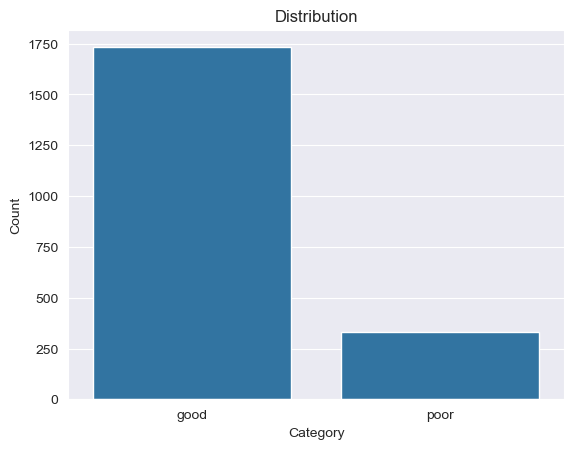

In [136]:
sns.countplot(x=target)
plt.title("Distribution")
plt.xlabel('Category')
plt.ylabel("Count")
plt.show()

### Neural Network on Original Features

In [198]:
# partition data
# -----------
y = label_encoder.fit_transform(target) # either hsd010 or hsd010_binary, may need to convert to numeric if it isn't already 
X = nhanes_scaled # drop out any columns that aren't features

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    stratify = y,
                                                    test_size = .25, 
                                                    random_state = 10)

In [200]:
y

array([0, 0, 0, ..., 1, 0, 0])

In [206]:
num_classes = 2

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

num_classes = y_test.shape[1]
num_features = X.shape[1]

In [208]:
# create neural network model
# -----------
model = Sequential()

model.add(Dense(num_features, 
                input_dim= num_features, 
                kernel_initializer= 'normal', 
                activation= 'relu'))

model.add(Dense(num_classes,                
          kernel_initializer='normal', 
          activation='sigmoid'))

model.compile(loss= 'binary_crossentropy', 
              optimizer= 'adam', 
            metrics=[F1Score( threshold=0.5, average='micro')] )

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train,                 
          y_train,                 
          validation_data=(X_test, 
                           y_test), 
          epochs=50,                
          batch_size=200,           
          verbose=2,
          callbacks=[early_stopping]
         )

Epoch 1/50


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 - 1s - 67ms/step - f1_score: 0.6607 - loss: 0.6108 - val_f1_score: 0.8251 - val_loss: 0.4609
Epoch 2/50
8/8 - 0s - 4ms/step - f1_score: 0.8554 - loss: 0.4012 - val_f1_score: 0.8602 - val_loss: 0.3772
Epoch 3/50
8/8 - 0s - 4ms/step - f1_score: 0.8675 - loss: 0.3354 - val_f1_score: 0.8666 - val_loss: 0.3680
Epoch 4/50
8/8 - 0s - 5ms/step - f1_score: 0.8721 - loss: 0.3104 - val_f1_score: 0.8687 - val_loss: 0.3650
Epoch 5/50
8/8 - 0s - 4ms/step - f1_score: 0.8867 - loss: 0.2900 - val_f1_score: 0.8684 - val_loss: 0.3583
Epoch 6/50
8/8 - 0s - 4ms/step - f1_score: 0.8973 - loss: 0.2692 - val_f1_score: 0.8676 - val_loss: 0.3526
Epoch 7/50
8/8 - 0s - 4ms/step - f1_score: 0.9032 - loss: 0.2527 - val_f1_score: 0.8732 - val_loss: 0.3469
Epoch 8/50
8/8 - 0s - 4ms/step - f1_score: 0.9071 - loss: 0.2362 - val_f1_score: 0.8702 - val_loss: 0.3428
Epoch 9/50
8/8 - 0s - 4ms/step - f1_score: 0.9134 - loss: 0.2222 - val_f1_score: 0.8674 - val_loss: 0.3399
Epoch 10/50
8/8 - 0s - 4ms/step - f1_score: 0.9

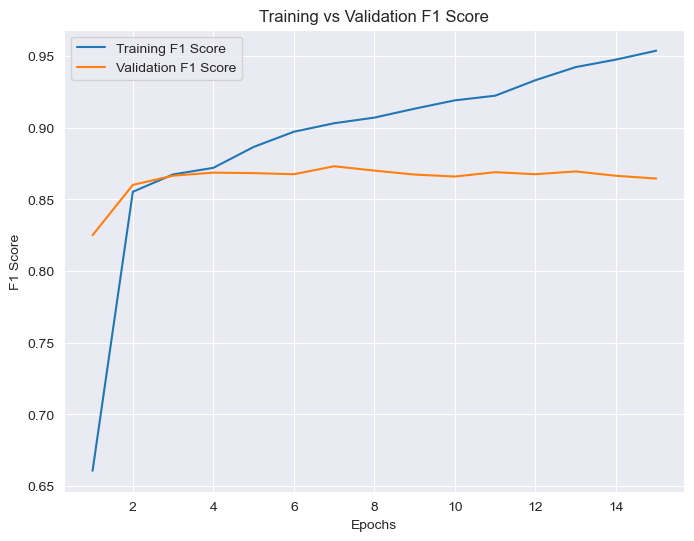

In [210]:
train_score = history.history['f1_score']
val_score = history.history['val_f1_score']

epochs = range(1, len(train_score) + 1)

plt.figure(figsize=(8, 6))
plt.plot(epochs, train_score, label='Training F1 Score')
plt.plot(epochs, val_score, label='Validation F1 Score')
plt.title('Training vs Validation F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.show()

#### Model Refinement: Add Hidden Layers

In [213]:
model_plus = Sequential()

model_plus.add(Dense(num_features, 
                input_dim= num_features, 
                kernel_initializer= 'normal', 
                activation= 'relu'))

model_plus.add(Dropout(0.5))
model_plus.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))

model_plus.add(Dense(num_classes,                
          kernel_initializer='normal', 
          activation='sigmoid'))

model_plus.compile(loss= 'binary_crossentropy', 
              optimizer= 'adam', 
            metrics=[F1Score( threshold=0.5, average='micro')] )

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model_plus.fit(X_train,                 
          y_train,                 
          validation_data=(X_test, 
                           y_test), 
          epochs=50,                
          batch_size=200,           
          verbose=2,
          callbacks=[early_stopping]
         )

Epoch 1/50


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 - 1s - 84ms/step - f1_score: 0.7392 - loss: 1.1640 - val_f1_score: 0.8459 - val_loss: 1.0513
Epoch 2/50
8/8 - 0s - 5ms/step - f1_score: 0.8472 - loss: 0.9758 - val_f1_score: 0.8457 - val_loss: 0.8911
Epoch 3/50
8/8 - 0s - 5ms/step - f1_score: 0.8424 - loss: 0.8311 - val_f1_score: 0.8496 - val_loss: 0.7854
Epoch 4/50
8/8 - 0s - 5ms/step - f1_score: 0.8472 - loss: 0.7281 - val_f1_score: 0.8543 - val_loss: 0.7205
Epoch 5/50
8/8 - 0s - 5ms/step - f1_score: 0.8562 - loss: 0.6588 - val_f1_score: 0.8532 - val_loss: 0.6674
Epoch 6/50
8/8 - 0s - 5ms/step - f1_score: 0.8630 - loss: 0.6002 - val_f1_score: 0.8622 - val_loss: 0.6197
Epoch 7/50
8/8 - 0s - 5ms/step - f1_score: 0.8753 - loss: 0.5449 - val_f1_score: 0.8639 - val_loss: 0.5780
Epoch 8/50
8/8 - 0s - 5ms/step - f1_score: 0.8797 - loss: 0.5024 - val_f1_score: 0.8716 - val_loss: 0.5417
Epoch 9/50
8/8 - 0s - 5ms/step - f1_score: 0.8827 - loss: 0.4604 - val_f1_score: 0.8718 - val_loss: 0.5114
Epoch 10/50
8/8 - 0s - 6ms/step - f1_score: 0.8

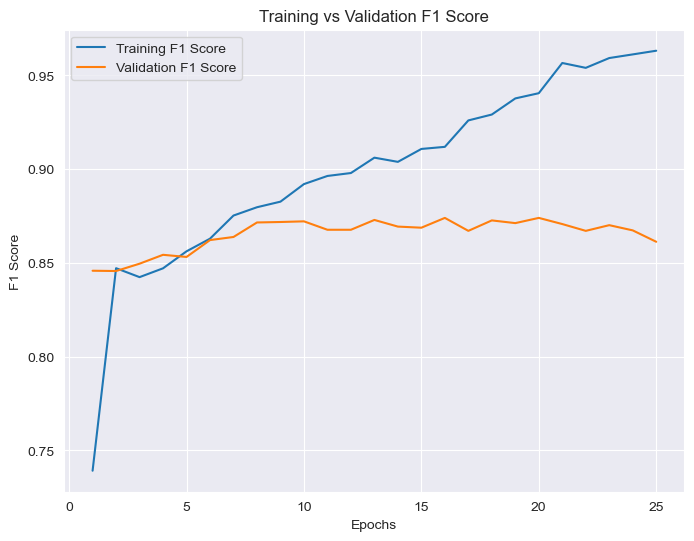

In [215]:
train_score = history.history['f1_score']
val_score = history.history['val_f1_score']

epochs = range(1, len(train_score) + 1)

plt.figure(figsize=(8, 6))
plt.plot(epochs, train_score, label='Training F1 Score')
plt.plot(epochs, val_score, label='Validation F1 Score')
plt.title('Training vs Validation F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.show()

In [241]:
model_plus.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_18 (Dense)                │ (None, 242)            │        58,806 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 242)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 32)             │         7,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 199,946 (781.04 KB)

 Trainable params: 66,648 (260.34 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 133,298 (520.70 KB)

### Neural Network on Principal Components

In [257]:
X_pca_19 = pca_df_19

X_pca_19_train, X_pca_19_test, y_train, y_test = train_test_split(X_pca_19, 
                                                    y,
                                                    stratify = y,
                                                    test_size = .25, 
                                                    random_state = 10)

In [259]:
num_classes = 2
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
num_classes = y_test.shape[1]

num_features = X_pca_19.shape[1]

In [261]:
model_pca_19 = Sequential()

model_pca_19.add(Dense(num_features, 
                input_dim= num_features, 
                kernel_initializer= 'normal', 
                activation= 'relu'))

model_pca_19.add(Dropout(0.5))

model_pca_19.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))

model_pca_19.add(Dense(num_classes,                
          kernel_initializer='normal', 
          activation='sigmoid'))

model_pca_19.compile(loss= 'binary_crossentropy', 
              optimizer= 'adam', 
            metrics=[F1Score( threshold=0.5, average='micro')] )

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_pca_19 = model_pca_19.fit(X_pca_19_train,                 
          y_train,                 
          validation_data=(X_pca_19_test, 
                           y_test), 
          epochs=50,                
          batch_size=200,           
          verbose=2,
          callbacks=[early_stopping]
         )

Epoch 1/50


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 - 1s - 81ms/step - f1_score: 0.6783 - loss: 0.9214 - val_f1_score: 0.7872 - val_loss: 0.9009
Epoch 2/50
8/8 - 0s - 4ms/step - f1_score: 0.8001 - loss: 0.8828 - val_f1_score: 0.8306 - val_loss: 0.8650
Epoch 3/50
8/8 - 0s - 4ms/step - f1_score: 0.8355 - loss: 0.8450 - val_f1_score: 0.8391 - val_loss: 0.8282
Epoch 4/50
8/8 - 0s - 4ms/step - f1_score: 0.8394 - loss: 0.8060 - val_f1_score: 0.8391 - val_loss: 0.7896
Epoch 5/50
8/8 - 0s - 4ms/step - f1_score: 0.8391 - loss: 0.7653 - val_f1_score: 0.8391 - val_loss: 0.7486
Epoch 6/50
8/8 - 0s - 4ms/step - f1_score: 0.8391 - loss: 0.7248 - val_f1_score: 0.8391 - val_loss: 0.7057
Epoch 7/50
8/8 - 0s - 4ms/step - f1_score: 0.8391 - loss: 0.6782 - val_f1_score: 0.8391 - val_loss: 0.6626
Epoch 8/50
8/8 - 0s - 4ms/step - f1_score: 0.8391 - loss: 0.6360 - val_f1_score: 0.8391 - val_loss: 0.6227
Epoch 9/50
8/8 - 0s - 4ms/step - f1_score: 0.8391 - loss: 0.6040 - val_f1_score: 0.8391 - val_loss: 0.5895
Epoch 10/50
8/8 - 0s - 4ms/step - f1_score: 0.8

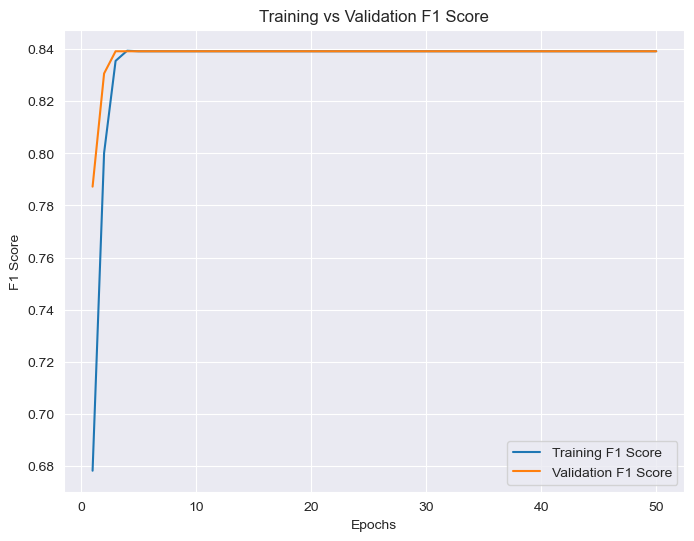

In [263]:
train_score = history_pca_19.history['f1_score']
val_score = history_pca_19.history['val_f1_score']

epochs = range(1, len(train_score) + 1)

plt.figure(figsize=(8, 6))
plt.plot(epochs, train_score, label='Training F1 Score')
plt.plot(epochs, val_score, label='Validation F1 Score')
plt.title('Training vs Validation F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.show()

In [265]:
model_pca_19.summary()

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_39 (Dense)                │ (None, 19)             │           380 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 19)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 32)             │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,260 (12.74 KB)

 Trainable params: 1,086 (4.24 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,174 (8.50 KB)

After reducing the original features to the first 19 principal components, the model’s performance seems to plateau quickly, achieving an F1 score of 0.83, which is lower than the model using original features,
This suggests that some meaningful information may have been lost during the PCA transformation, as the reduced components only captures about 45% variance in the original features. Given that, I will use the first 120 principle components to keep 90% explained variance.

In [267]:
X_pca_120 = pca_df_120

X_pca_120_train, X_pca_120_test, y_train, y_test = train_test_split(X_pca_120, 
                                                    y,
                                                    stratify = y,
                                                    test_size = .25, 
                                                    random_state = 10)

num_classes = 2
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
num_classes = y_test.shape[1]

num_features = X_pca_120.shape[1]

In [269]:
model_pca_120 = Sequential()

model_pca_120.add(Dense(num_features, 
                input_dim= num_features, 
                kernel_initializer= 'normal', 
                activation= 'relu'))

model_pca_120.add(Dropout(0.5))

model_pca_120.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))

model_pca_120.add(Dense(num_classes,                
          kernel_initializer='normal', 
          activation='sigmoid'))

model_pca_120.compile(loss= 'binary_crossentropy', 
              optimizer= 'adam', 
            metrics=[F1Score( threshold=0.5, average='micro')] )

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_pca_120 = model_pca_120.fit(X_pca_120_train,                 
          y_train,                 
          validation_data=(X_pca_120_test, 
                           y_test), 
          epochs=50,                
          batch_size=200,           
          verbose=2,
          callbacks=[early_stopping]
         )

Epoch 1/50


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 - 1s - 122ms/step - f1_score: 0.2734 - loss: 1.1886 - val_f1_score: 0.5799 - val_loss: 1.1216
Epoch 2/50
8/8 - 0s - 5ms/step - f1_score: 0.7133 - loss: 1.0761 - val_f1_score: 0.8333 - val_loss: 1.0234
Epoch 3/50
8/8 - 0s - 5ms/step - f1_score: 0.8362 - loss: 0.9745 - val_f1_score: 0.8416 - val_loss: 0.9284
Epoch 4/50
8/8 - 0s - 5ms/step - f1_score: 0.8398 - loss: 0.8801 - val_f1_score: 0.8391 - val_loss: 0.8384
Epoch 5/50
8/8 - 0s - 5ms/step - f1_score: 0.8388 - loss: 0.7927 - val_f1_score: 0.8391 - val_loss: 0.7589
Epoch 6/50
8/8 - 0s - 5ms/step - f1_score: 0.8394 - loss: 0.7136 - val_f1_score: 0.8391 - val_loss: 0.6960
Epoch 7/50
8/8 - 0s - 5ms/step - f1_score: 0.8408 - loss: 0.6466 - val_f1_score: 0.8416 - val_loss: 0.6468
Epoch 8/50
8/8 - 0s - 5ms/step - f1_score: 0.8403 - loss: 0.5924 - val_f1_score: 0.8447 - val_loss: 0.6070
Epoch 9/50
8/8 - 0s - 5ms/step - f1_score: 0.8447 - loss: 0.5504 - val_f1_score: 0.8494 - val_loss: 0.5740
Epoch 10/50
8/8 - 0s - 7ms/step - f1_score: 0.

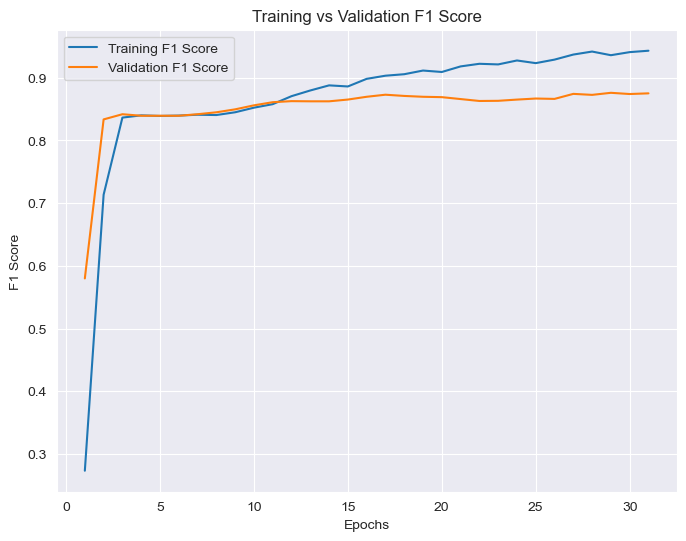

In [271]:
train_score = history_pca_120.history['f1_score']
val_score = history_pca_120.history['val_f1_score']

epochs = range(1, len(train_score) + 1)

plt.figure(figsize=(8, 6))
plt.plot(epochs, train_score, label='Training F1 Score')
plt.plot(epochs, val_score, label='Validation F1 Score')
plt.title('Training vs Validation F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.show()

In [273]:
model_pca_120.summary()

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_42 (Dense)                │ (None, 120)            │        14,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 32)             │         3,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 55,376 (216.32 KB)

 Trainable params: 18,458 (72.10 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 36,918 (144.21 KB)

### Neural Network on Principal Components + Cluster Membership

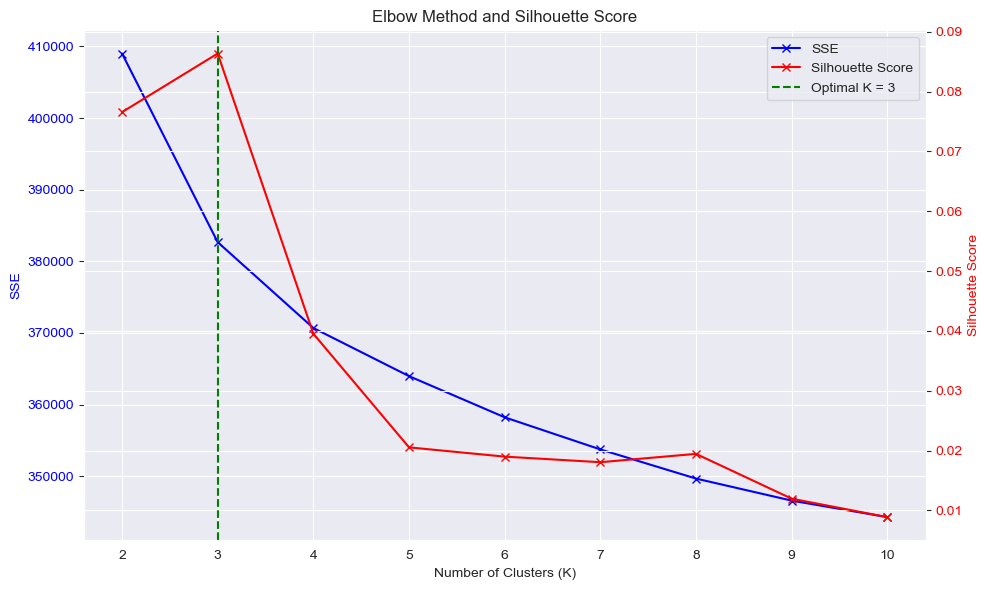

In [275]:
sse = []
silhouette_scores = []
k_values = range(2, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=10)
    kmeans.fit(pca_df_120)
    
    sse.append(kmeans.inertia_)
    
    labels = kmeans.labels_
    silhouette_scores.append(silhouette_score(nhanes_scaled, labels))


fig, ax1 = plt.subplots(figsize=(10, 6))

sse_line, = ax1.plot(k_values, sse, 'bx-', label='SSE')
ax1.set_xlabel('Number of Clusters (K)')
ax1.set_ylabel('SSE', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
silhouette_line, = ax2.plot(k_values, silhouette_scores, 'rx-', label='Silhouette Score')
ax2.set_ylabel('Silhouette Score', color='red')
ax2.tick_params(axis='y', labelcolor='red')

optimal_k = plt.axvline(x=3, color='g', linestyle='--', label=f"Optimal K = 3")

lines = [sse_line, silhouette_line, optimal_k]  
labels = [line.get_label() for line in lines]
plt.legend(lines, labels, loc='best')

plt.title('Elbow Method and Silhouette Score')
fig.tight_layout()

plt.show()

In [277]:
kmeans = KMeans(n_clusters=3,
                n_init=10,
                max_iter=300,
                random_state = 10).fit(pca_df_2d)

pca_120_kmeans = pca_df_120.copy()
pca_120_kmeans['cluster']  = kmeans.labels_

In [279]:
X_pca_cluster = pca_120_kmeans

X_pca_cluster_train, X_pca_cluster_test, y_train, y_test = train_test_split(X_pca_cluster, 
                                                    y,
                                                    stratify = y,
                                                    test_size = .25, 
                                                    random_state = 10)

num_classes = 2
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
num_classes = y_test.shape[1]

num_features = X_pca_cluster.shape[1]

In [283]:
model_pca_cluster = Sequential()

model_pca_cluster.add(Dense(num_features, 
                input_dim= num_features, 
                kernel_initializer= 'normal', 
                activation= 'relu'))

model_pca_cluster.add(Dropout(0.5))

model_pca_cluster.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))

model_pca_cluster.add(Dense(num_classes,                
          kernel_initializer='normal', 
          activation='sigmoid'))

model_pca_cluster.compile(loss= 'binary_crossentropy', 
              optimizer= 'adam', 
            metrics=[F1Score( threshold=0.5, average='micro')] )

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_pca_cluster = model_pca_cluster.fit(X_pca_cluster_train,                 
          y_train,                 
          validation_data=(X_pca_cluster_test, 
                           y_test), 
          epochs=50,                
          batch_size=200,           
          verbose=2,
          callbacks=[early_stopping]
         )

Epoch 1/50


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 - 1s - 87ms/step - f1_score: 0.7175 - loss: 1.1393 - val_f1_score: 0.8403 - val_loss: 1.0832
Epoch 2/50
8/8 - 0s - 4ms/step - f1_score: 0.8317 - loss: 1.0371 - val_f1_score: 0.8391 - val_loss: 0.9876
Epoch 3/50
8/8 - 0s - 5ms/step - f1_score: 0.8388 - loss: 0.9378 - val_f1_score: 0.8391 - val_loss: 0.8927
Epoch 4/50
8/8 - 0s - 5ms/step - f1_score: 0.8391 - loss: 0.8393 - val_f1_score: 0.8391 - val_loss: 0.8047
Epoch 5/50
8/8 - 0s - 5ms/step - f1_score: 0.8391 - loss: 0.7513 - val_f1_score: 0.8391 - val_loss: 0.7317
Epoch 6/50
8/8 - 0s - 4ms/step - f1_score: 0.8391 - loss: 0.6829 - val_f1_score: 0.8391 - val_loss: 0.6759
Epoch 7/50
8/8 - 0s - 5ms/step - f1_score: 0.8391 - loss: 0.6249 - val_f1_score: 0.8391 - val_loss: 0.6316
Epoch 8/50
8/8 - 0s - 4ms/step - f1_score: 0.8391 - loss: 0.5738 - val_f1_score: 0.8391 - val_loss: 0.5935
Epoch 9/50
8/8 - 0s - 4ms/step - f1_score: 0.8391 - loss: 0.5301 - val_f1_score: 0.8419 - val_loss: 0.5606
Epoch 10/50
8/8 - 0s - 4ms/step - f1_score: 0.8

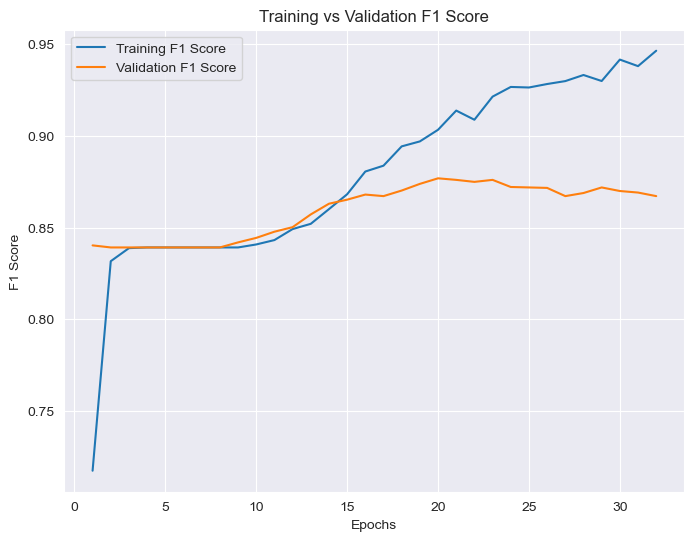

In [287]:
train_score = history_pca_cluster.history['f1_score']
val_score = history_pca_cluster.history['val_f1_score']

epochs = range(1, len(train_score) + 1)

plt.figure(figsize=(8, 6))
plt.plot(epochs, train_score, label='Training F1 Score')
plt.plot(epochs, val_score, label='Validation F1 Score')
plt.title('Training vs Validation F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.show()

## Discussion Questions

1. In your own words, what is the difference between PCA and clustering?

Clustering looks for **similar** datapoints based on all original features but PCA focuses on **variance** in the data.  
The goal of PCA is to identify k directions, known as principal components, that capture most of the variation in the data. These principal components are linear combinations of the original features. Unlike subset selection methods like LASSO, PCA does not select individual features but instead creates new directions that are diagonal or rotated compared to the original axes.
Clustering aims to discover natural subgroups within the data based on inherent patterns or similarities. And instead of reducing the number of features, clustering reduces the meaningful entities and simplify the original dataset.

2. Did you notice any advantages to combining PCA and clustering? If so, what do you think they were? If not, why do you think you didn't see any gains from this combination?

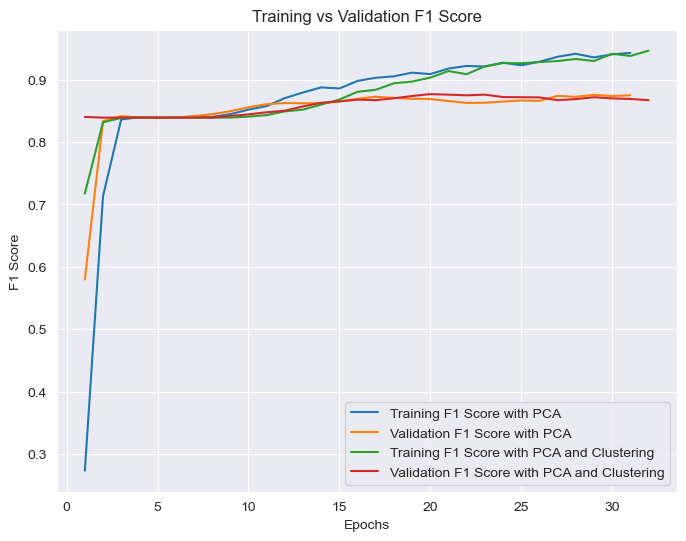

In [293]:
train_score_pca = history_pca_120.history['f1_score']
val_score_pca = history_pca_120.history['val_f1_score']
train_score_pca_cluster = history_pca_cluster.history['f1_score']
val_score_pca_cluster = history_pca_cluster.history['val_f1_score']

epochs_pca = range(1, len(train_score_pca) + 1)
epochs_pca_cluster = range(1, len(train_score_pca_cluster) + 1)

plt.figure(figsize=(8, 6))
plt.plot(epochs_pca, train_score_pca, label='Training F1 Score with PCA')
plt.plot(epochs_pca, val_score_pca, label='Validation F1 Score with PCA')
plt.plot(epochs_pca_cluster, train_score_pca_cluster, label='Training F1 Score with PCA and Clustering')
plt.plot(epochs_pca_cluster, val_score_pca_cluster, label='Validation F1 Score with PCA and Clustering')
plt.title('Training vs Validation F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.show()

The two models exhibit **similar final predictive performance**, but the model with clustering demonstrates **better initial performance**.  
This suggests that clustering membership is a strong predictor, likely revealing latent structures or patterns in the data that are not directly evident from individual features. These latent structures may align closely with the separations required by the target variable, making clustering a powerful feature in the early stages of learning.
However, even without clustering as preprocessing, the neural network model can eventually learn these latent patterns from the principal components. This allows the two models to converge to nearly identical performance in the end.

3. How can unsupervised techniques help with downstream supervised learning tasks when working with "big data?"

Using clustering as preprocessing can potentially **speed up downstream supervised learning** by providing a strong initial representation and reducing the complexity of the learning task. 
On the other hand, applying PCA for dimensionality reduction primarily addresses the **“curse of dimensionality.”** When there are many features, datapoints in high-dimensional spaces become sparse, making it more difficult for supervised models to make accurate predictions because new datapoints may be very far from those in the training set. In high dimensions, predictions are generally less reliable compared to lower-dimensional spaces because they rely on greater extrapolation, increasing the risk of overfitting. PCA mitigates these issues by projecting the data into a lower-dimensional space, retaining the most informative features while reducing noise and redundancy, which helps improve model generalization.

**Reference:**  

Géron, A. (2019). *Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems*. “O’Reilly Media, Inc.”